In [1]:
import pandas as pd
import numpy as np
import json
import os

from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

In [2]:
def update_df_with_stats(df, wikipage_queries_path, categories_relevance_scores_dir, navigation_links_relevance_scores_dir):
    '''
    Updates the input dataframe by computing the following for each query:
    
    * tuple width 
    * number of tuples
    * categories relevant wikipages
    * categories relevant tables
    * navigation links relevant wikipages
    * navigation links relevant tables
    * categories expansion ratio
    * navigation links expansion ratio
    '''
    # Loop over the the queries for each wikipedia page and identify their tuple width and number of tuples to update df
    df['tuple_width'] = np.nan
    df['num_tuples'] = np.nan
    df['categories_relevant_wikipages'] = np.nan
    df['categories_relevant_tables'] = np.nan
    df['navigation_links_relevant_wikipages'] = np.nan
    df['navigation_links_relevant_tables'] = np.nan
    df['categories_expansion_ratio'] = np.nan
    df['navigation_links_expansion_ratio'] = np.nan

    for idx, row in tqdm(df.iterrows(), total=len(df.index)):
        # Read query file and update df with the tuple_width and num_tuples for each query
        with open(wikipage_queries_path+'wikipage_'+str(row['wikipage_id'])+'.json', 'r') as fp:
            query = json.load(fp)['queries']
        
        tuple_width = len(query[0])
        num_tuples = len(query)
        df.loc[idx, 'tuple_width'] = tuple_width
        df.loc[idx, 'num_tuples'] = num_tuples

        # Read the categories relevance scores file
        with open(categories_relevance_scores_dir+str(row['wikipage_id'])+'.json', 'r') as fp:
            categories_relevance = json.load(fp)
        df.loc[idx, 'categories_relevant_wikipages'] = len(categories_relevance)
        categories_relevant_tables = len(get_relevant_tables(df=df, wikipage_id=row['wikipage_id'], relevance_scores_dir=categories_relevance_scores_dir))
        df.loc[idx, 'categories_relevant_tables'] = categories_relevant_tables

        # Read the navigation links relevance scores file
        with open(navigation_links_relevance_scores_dir+str(row['wikipage_id'])+'.json', 'r') as fp:
            navigation_links_relevance = json.load(fp)
        df.loc[idx, 'navigation_links_relevant_wikipages'] = len(navigation_links_relevance)
        navigation_links_relevant_tables = len(get_relevant_tables(df=df, wikipage_id=row['wikipage_id'], relevance_scores_dir=navigation_links_relevance_scores_dir))
        df.loc[idx, 'navigation_links_relevant_tables'] = navigation_links_relevant_tables

        # Compute the expansion ratios
        df.loc[idx, 'categories_expansion_ratio'] = df.loc[idx, 'categories_relevant_tables'] / df.loc[idx, 'num_tables']
        df.loc[idx, 'navigation_links_expansion_ratio'] = df.loc[idx, 'navigation_links_relevant_tables'] / df.loc[idx, 'num_tables'] 

    return df

def get_relevant_tables(df, wikipage_id, relevance_scores_dir):
    '''
    Given a query from a `wikipage` return a list of all its relevant tables using the specified `relevance_scores_dir`
    '''
    with open(relevance_scores_dir+str(wikipage_id)+'.json', 'r') as fp:
        relevance_dict = json.load(fp)
    
    relevant_tables = []
    for wikipage_name in relevance_dict:
        relevant_tables += df.loc[df['wikipage']=='https://en.wikipedia.org/wiki/' + wikipage_name]['tables'].values[0]
    return relevant_tables

# Wikipages Dataset

In [3]:
df_path = 'query_dataframes/minTupleWidth_all_tuplesPerQuery_all.pickle'
wikipage_queries_path = 'queries/minTupleWidth_all_tuplesPerQuery_all/'
categories_relevance_scores_dir = 'groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard_categories/'
navigation_links_relevance_scores_dir = 'groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard_navigation_links/'

df = pd.read_pickle(df_path)
df = update_df_with_stats(df, wikipage_queries_path, categories_relevance_scores_dir, navigation_links_relevance_scores_dir)
df

100%|██████████| 1418/1418 [00:13<00:00, 102.47it/s]


,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,categories_relevant_tables,navigation_links_relevant_wikipages,navigation_links_relevant_tables,categories_expansion_ratio,navigation_links_expansion_ratio
124,"https://en.wikipedia.org/wiki/List_of_Murder,_...",124,20,"[table-0001-805.json, table-0001-806.json, tab...","[50, 19, 52, 66, 124, 29, 12, 68, 59, 101, 130...",1.0,130.0,table-0001-816.json,"[0, 1, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",1.0,20.0,1.0,20.0,1.000000,1.000000
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,29.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22, 24, 25, ...",2.0,28.0,1.0,10.0,2.800000,1.000000
849,https://en.wikipedia.org/wiki/1994_NHL_Entry_D...,849,12,"[table-0005-960.json, table-0005-961.json, tab...","[74, 18, 20, 12, 36, 34, 26, 20, 18, 16, 10, 21]",5.0,2.0,table-0005-960.json,"[0, 6]",28.0,307.0,33.0,364.0,25.583333,30.333333
1955,https://en.wikipedia.org/wiki/List_of_automobi...,1955,13,"[table-0012-625.json, table-0012-628.json, tab...","[27, 31, 41, 30, 15, 19, 11, 18, 20, 26, 15, 5...",2.0,10.0,table-0012-629.json,"[2, 6, 7, 10, 16, 20, 22, 26, 28, 30]",1.0,13.0,1.0,13.0,1.000000,1.000000
1996,https://en.wikipedia.org/wiki/List_of_Unicode_...,1996,14,"[table-0012-802.json, table-0012-809.json, tab...","[70, 214, 24, 19, 25, 83, 14, 13, 63, 67, 123,...",16.0,16.0,table-0012-950.json,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",1.0,14.0,1.0,14.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243867,https://en.wikipedia.org/wiki/List_of_people_o...,243867,20,"[table-1651-752.json, table-1651-753.json, tab...","[17, 154, 51, 10, 33, 37, 11, 99, 32, 26, 118,...",3.0,7.0,table-1651-760.json,"[106, 158, 170, 178, 190, 202, 211]",2.0,36.0,1.0,20.0,1.800000,1.000000
243879,https://en.wikipedia.org/wiki/List_of_blue_pla...,243879,13,"[table-1651-832.json, table-1651-835.json, tab...","[29, 28, 39, 39, 23, 34, 101, 23, 42, 168, 35,...",4.0,5.0,table-1651-851.json,"[4, 11, 29, 95, 100]",1.0,13.0,1.0,13.0,1.000000,1.000000
243999,https://en.wikipedia.org/wiki/List_of_James_Bo...,243999,10,"[table-1652-462.json, table-1652-464.json, tab...","[22, 23, 16, 21, 23, 16, 84, 20, 33, 38]",4.0,2.0,table-1652-478.json,"[5, 13]",1.0,10.0,1.0,10.0,1.000000,1.000000
244040,https://en.wikipedia.org/wiki/List_of_World_Aq...,244040,16,"[table-1652-649.json, table-1652-651.json, tab...","[31, 37, 41, 37, 36, 38, 41, 28, 29, 40, 27, 4...",4.0,15.0,table-1652-658.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",10.0,163.0,4.0,62.0,10.187500,3.875000


In [4]:
print("Total number of Categories Relevant Tables:", df['categories_relevant_tables'].sum())
print("Total number of Navigation Links Relevant Tables:", df['navigation_links_relevant_tables'].sum())

Total number of Categories Relevant Tables: 124011.0
Total number of Navigation Links Relevant Tables: 177453.0


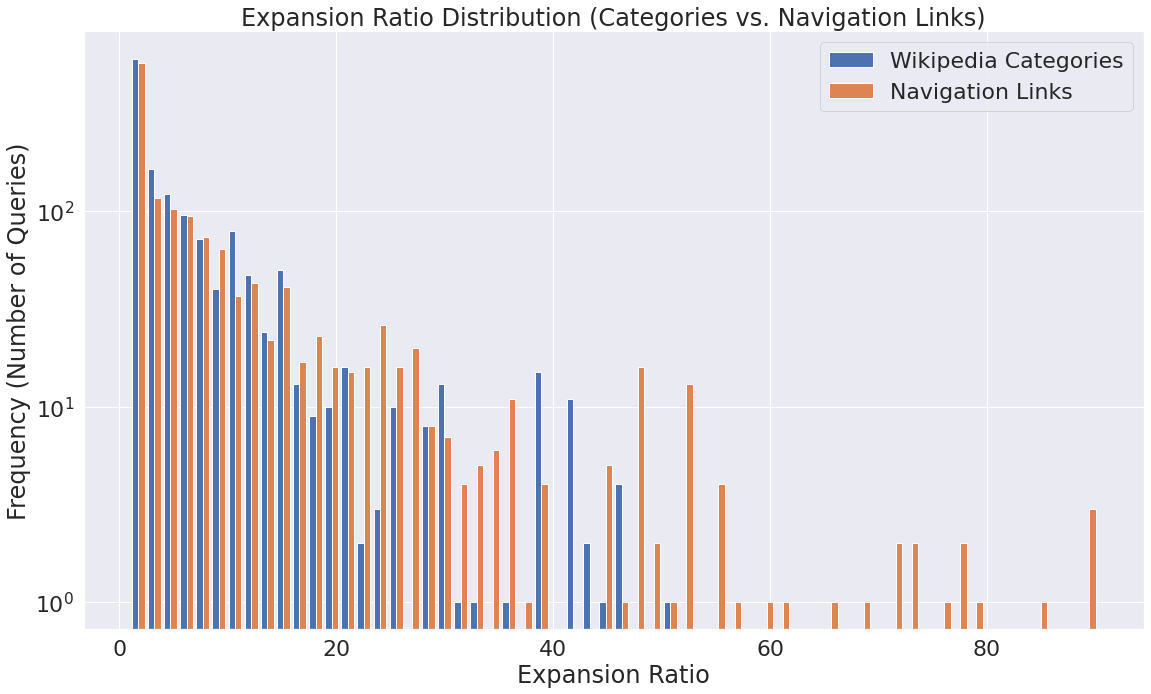

In [5]:
ax = plt.hist([df['categories_expansion_ratio'], df['navigation_links_expansion_ratio']], bins=60, label=['Wikipedia Categories','Navigation Links'])
plt.yscale('log');plt.xlabel("Expansion Ratio");plt.ylabel("Frequency (Number of Queries)");plt.title("Expansion Ratio Distribution (Categories vs. Navigation Links)");plt.legend()

## Extract Filtered Queries

In [7]:
# Filter down the queries to be used (ideally select queries with enough tuples and sizable expansion ratios)
df_filtered = df[(df['num_tuples'] >= 10) & (df['tuple_width'] >= 3)]
df_filtered = df_filtered[(df_filtered['categories_expansion_ratio'] >= 3) & (df_filtered['navigation_links_expansion_ratio'] >= 3)]

# Manually remove certain queries that are repeated or not great for evaluation
wikipage_ids_to_remove = [122488, 126546, 117835, 92182, 234096, 234076, 84372, 110477, 21717, 16451, 237262, 78883, 131093, 201049, 193783, 23713, 36981, 173244, 74738, 70306, 40257, 96516, 2920, 11161, 61076, 120067, 104266, 104150, 104152, 119877, 104151, 81498, 110282, 157394, 122838, 131622]
df_filtered = df_filtered[~df_filtered['wikipage_id'].isin(wikipage_ids_to_remove)]

# Save the filtered queries
df_filtered.to_pickle('query_dataframes/filtered_queries/minTupleWidth_all_tuplesPerQuery_all.pickle')

print("There are:", len(df_filtered.index), "queries selected after filtering")
print("Mean number of categories relevant tables per query:", df_filtered['categories_relevant_tables'].mean())
print("Mean number of navigation links relevant tables per query:", df_filtered['navigation_links_relevant_tables'].mean())

# Count total number of unique relevant tables between categories and navigation links in the filtered queries
categories_relevant_tables = set()
navigation_links_relevant_tables = set()
for idx, row in df_filtered.iterrows():
    categories_relevant_tables.update(get_relevant_tables(df=df, wikipage_id=row['wikipage_id'], relevance_scores_dir=categories_relevance_scores_dir))
    navigation_links_relevant_tables.update(get_relevant_tables(df=df, wikipage_id=row['wikipage_id'], relevance_scores_dir=navigation_links_relevance_scores_dir))
print("There are a total of:", len(categories_relevant_tables), 'unique relevant tables using Categories')
print("There are a total of:", len(navigation_links_relevant_tables), 'unique relevant tables using Navigation Links')

There are: 47 queries selected after filtering
Mean number of categories relevant tables per query: 106.95744680851064
Mean number of navigation links relevant tables per query: 106.27659574468085
There are a total of: 2784 unique relevant tables using Categories
There are a total of: 3023 unique relevant tables using Navigation Links


Text(0.5, 1.0, '# of relevant tables (Filtered 26 Queries)')

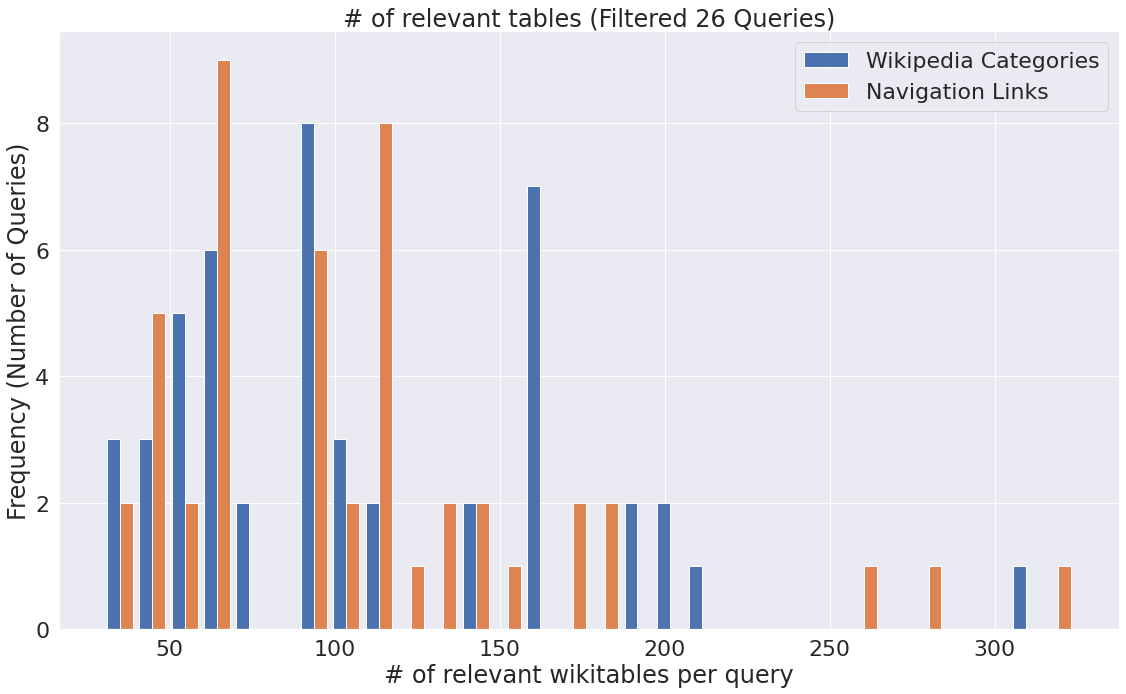

In [8]:
ax = plt.hist([df_filtered['categories_relevant_tables'], df_filtered['navigation_links_relevant_tables']], bins=30, label=['Wikipedia Categories','Navigation Links'])
plt.legend();plt.ylabel("Frequency (Number of Queries)");plt.xlabel("# of relevant wikitables per query");plt.title("# of relevant tables (Filtered 26 Queries)")

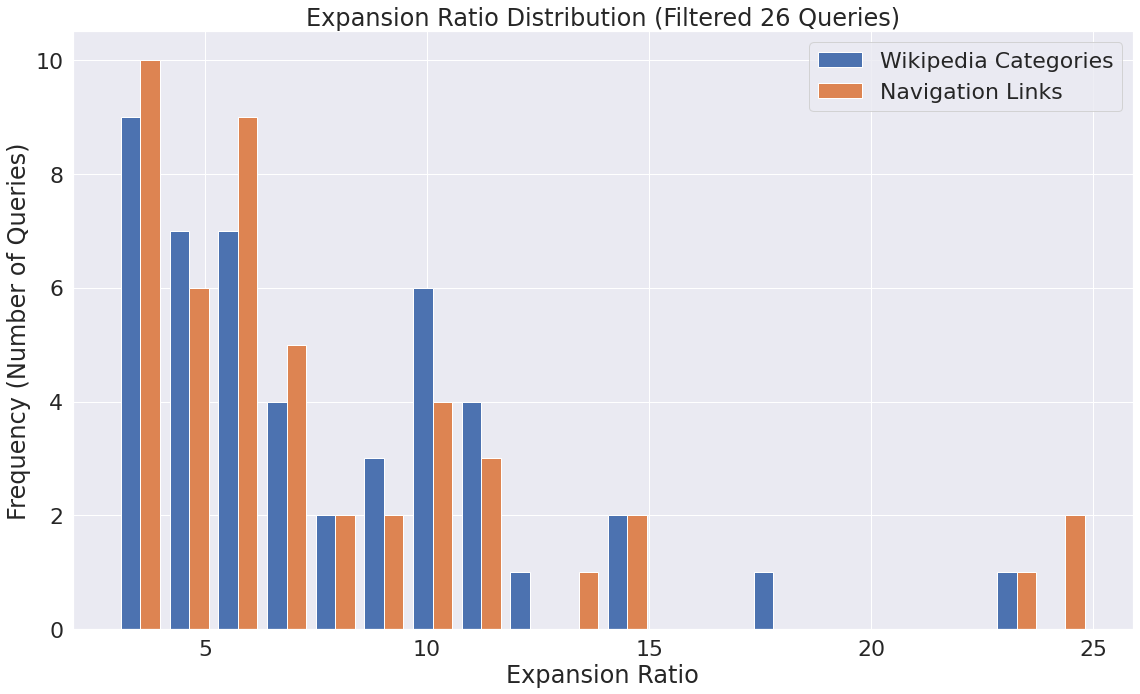

In [9]:
ax = plt.hist([df_filtered['categories_expansion_ratio'], df_filtered['navigation_links_expansion_ratio']], bins=20, label=['Wikipedia Categories','Navigation Links'])
plt.xlabel("Expansion Ratio");plt.ylabel("Frequency (Number of Queries)");plt.title("Expansion Ratio Distribution (Filtered 26 Queries)");plt.legend()

In [ ]:
str = '''https://en.wikipedia.org/wiki/1982_Grand_Prix_(tennis) 122488
https://en.wikipedia.org/wiki/1986_NHL_Entry_Draft 126546
https://en.wikipedia.org/wiki/1996_NHL_Entry_Draft 117835
https://en.wikipedia.org/wiki/1997_NHL_Entry_Draft 92182
https://en.wikipedia.org/wiki/1998_NHL_Entry_Draft 234096
https://en.wikipedia.org/wiki/1999_NHL_Entry_Draft 234076
https://en.wikipedia.org/wiki/2000_NHL_Entry_Draft 84372
https://en.wikipedia.org/wiki/2001_NHL_Entry_Draft 110477
https://en.wikipedia.org/wiki/2002_NHL_Entry_Draft 21717
https://en.wikipedia.org/wiki/2003_NHL_Entry_Draft 16451
https://en.wikipedia.org/wiki/2004_NHL_Entry_Draft 237262
https://en.wikipedia.org/wiki/2005_NHL_Entry_Draft 78883
https://en.wikipedia.org/wiki/2006_NHL_Entry_Draft 131093
https://en.wikipedia.org/wiki/2007_NHL_Entry_Draft 201049
https://en.wikipedia.org/wiki/1988_ATP_Challenger_Series 193783
https://en.wikipedia.org/wiki/1992_ATP_Tour 23713
https://en.wikipedia.org/wiki/1995_ATP_Tour 36981
https://en.wikipedia.org/wiki/2013_ATP_Challenger_Tour 173244
https://en.wikipedia.org/wiki/2010_ATP_Challenger_Tour 74738
https://en.wikipedia.org/wiki/2009_ATP_Challenger_Tour 70306
https://en.wikipedia.org/wiki/2008_ATP_Challenger_Series 40257
https://en.wikipedia.org/wiki/1995_Rugby_League_World_Cup_squads 96516
https://en.wikipedia.org/wiki/1997_MLS_Expansion_Draft 2920
https://en.wikipedia.org/wiki/2004_MLS_Expansion_Draft 11161
https://en.wikipedia.org/wiki/2009_Boston_Red_Sox_season 61076
https://en.wikipedia.org/wiki/2011_Chicago_White_Sox_season 120067
https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes_(1951–60) 104266
https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes_(1971–80) 104150
https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes_(1981–90) 104152
https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes_(1991–2000) 119877
https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes_(2001–10) 104151
https://en.wikipedia.org/wiki/List_of_United_States_tornadoes_in_April_2009 81498
https://en.wikipedia.org/wiki/List_of_United_States_tornadoes_in_May_2010 110282
https://en.wikipedia.org/wiki/List_of_football_clubs_in_Indonesia 157394
https://en.wikipedia.org/wiki/Shooting_at_the_2010_Asian_Games 122838
https://en.wikipedia.org/wiki/Shooting_at_the_2002_Asian_Games 131622'''

%pprint
str = str.replace('\n', ' ')
str = str.split(' ')
wikipage_ids_to_remove = []
for val in str:
    if val.isdigit():
        wikipage_ids_to_remove.append(int(val))
wikipage_ids_to_remove


# Expanded Wikipages Dataset